In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
# read a CSV into a dataframe (adjust filename as needed)
events_filename = './data/event.csv'  # or provide a full path

if not os.path.exists(events_filename):
    csv_files = [f for f in os.listdir('.') if f.lower().endswith('.csv')]
    if not csv_files:
        raise FileNotFoundError(f"{events_filename!r} not found and no CSV files in the current directory.")
    filename = csv_files[0]
    print(f"No file named 'data.csv' found. Using first CSV in cwd: {filename}")

events = pd.read_csv(events_filename)
print(f"Loaded {len(events)} rows and {len(events.columns)} columns from {events_filename}")
events.head()

Loaded 107738 rows and 14 columns from ./data/event.csv


/var/folders/_b/sl_t4k5539781f29qf723b080000gn/T/ipykernel_63554/2221732598.py:11: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  events = pd.read_csv(events_filename)


,type,inPlay,isStrike,isBall,pitcherName,catcherName,batterName,pitchCode,pitchType,velocity,coordX,coordY,runners,PAId
0,PITCH,False,False,True,徐若熙,蔣少宏,陳晨威,B,FF,145,71.11,-91.43,[],NaN
1,PITCH,True,True,False,徐若熙,蔣少宏,陳晨威,H,FF,147,54.86,42.67,"[{'type': 'PA', 'runnerName': '陳晨威', 'isOut': ...",NaN
2,PITCH,False,True,False,徐若熙,蔣少宏,林立,F,FF,145,54.86,22.35,[],NaN
3,PITCH,False,True,False,徐若熙,蔣少宏,林立,SW,SL,135,-2.03,-56.89,[],NaN
4,PITCH,False,False,True,徐若熙,蔣少宏,林立,B,SL,139,-34.54,-144.25,[],NaN


In [3]:
events['coordX'] = events['coordX'] * 0.5 * 0.3937  # convert cm to inches and scale X
events['coordY'] = events['coordY'] * 0.5 * 0.3937  # convert cm to inches and scale Y

In [4]:
### filter out non-PITCH type
# test_events = events[((events['pitcherName'] == '古林睿煬')) & (events['type'] == 'PITCH')]
test_events = events[((events['batterName'] == '魔鷹')) & (events['type'] == 'PITCH')]

In [5]:
print(test_events.shape)
test_events.head()

(1882, 14)


,type,inPlay,isStrike,isBall,pitcherName,catcherName,batterName,pitchCode,pitchType,velocity,coordX,coordY,runners,PAId
284,PITCH,False,True,False,徐基麟,徐博瑋,魔鷹,F,CH,128,11.501945,10.895648,[],NaN
285,PITCH,True,True,False,徐基麟,徐博瑋,魔鷹,H,CH,131,5.570855,-3.190939,"[{'type': 'PA', 'runnerName': '魔鷹', 'isOut': F...",NaN
311,PITCH,False,False,True,徐基麟,徐博瑋,魔鷹,B,FF,143,-24.458613,3.852355,[],NaN
312,PITCH,False,False,True,徐基麟,徐博瑋,魔鷹,B,FF,144,-18.525554,-5.415344,[],NaN
313,PITCH,False,True,False,徐基麟,徐博瑋,魔鷹,SW,FF,144,12.242101,12.007850,[],NaN


In [6]:
strike_zone_width = 17.0 + 2.9 # plate width + margin (one ball width on each side)
strike_zone_height = strike_zone_width * 1.2
strike_zone = [-strike_zone_width/2, strike_zone_width/2, -strike_zone_height/2, strike_zone_height/2] # left, right, bottom, top

In [7]:
# define result groups (keep consistent with earlier cells)
hits = {'1B', '2B', '3B', 'HR', 'IHR', 'H'}
bbs = {'uBB', 'IBB'}
hbps = {'HBP'}
non_ab_results = {'SH', 'SF', 'uBB', 'IBB', 'HBP', 'IH', 'IR', 'ID'}
tb_map = {'1B': 1, 'H': 1, '2B': 2, '3B': 3, 'HR': 4, 'IHR': 4}
_swing_tokens = {'SW', 'F', 'FT', 'FOUL_BUNT', 'TRY_BUNT', 'BUNT', 'H'}
_fastball_tokens = {'FF', 'SI', 'FC'} # four-seam, sinker, cutter
_offspeed_tokens = {'CH', 'FO', 'FS', 'KN', 'EP'} # changeup, forkball, split-finger, knuckleball
_breaking_tokens = {'CU', 'SL'} # curveball, slider

In [8]:
def assign_counts_to_pitches(df):
    # iterate rows in order and track balls/strikes for the current plate appearance
    balls = 0
    strikes = 0
    records = []
    for idx, row in df.sort_index().iterrows():
        if row.get('type') != 'PITCH':
            # ignore non-pitch rows for assignment, but if they indicate PA boundary we could reset;
            # we keep simple behavior (resets will happen on inPlay/PA markers below)
            continue

        # record count before this pitch
        records.append((idx, balls, strikes))

        # update counts based on pitch outcome flags (simple, robust heuristics)
        is_ball = bool(row.get('isBall', False))
        is_strike = bool(row.get('isStrike', False))
        in_play = bool(row.get('inPlay', False))

        # ball increments balls
        if is_ball and not is_strike:
            balls += 1
        # strike increments strikes (but fouls shouldn't push above 2)
        elif is_strike and not is_ball:
            # only increment on non-inplay strikes; fouls often set isStrike True but rules cap at 2
            if not in_play and strikes < 2:
                strikes += 1

        # if the pitch resulted in the ball being put in play or runners indicate a PA event, end the plate appearance
        runners = row.get('runners', [])
        pa_marker = False
        if isinstance(runners, list):
            for r in runners:
                if isinstance(r, dict) and r.get('type') == 'PA':
                    pa_marker = True
                    break

        if in_play or pa_marker or balls >= 4 or strikes >= 3:
            balls = 0
            strikes = 0

    # build a small DataFrame keyed by original index
    counts_df = pd.DataFrame(records, columns=['index', 'balls', 'strikes']).set_index('index')
    return counts_df

In [9]:

# assign counts to all pitch rows
counts_df = assign_counts_to_pitches(events)

# merge counts into the pitches DataFrame we want to plot (test_events is already filtered to the pitcher/type)
# ensure indices align (counts_df contains only indices for PITCH rows)
test_events = test_events.join(counts_df, how='left')  # balls/strikes will be NaN if reconstruction failed for some rows

# fill missing with 0-0 to avoid issues (or drop NaNs if preferred)
test_events['balls'] = test_events['balls'].fillna(0).astype(int)
test_events['strikes'] = test_events['strikes'].fillna(0).astype(int)

In [10]:
def get_whiff_events(events_parent):
    in_swing = events_parent['pitchCode'].isin(_swing_tokens)
    in_sw = events_parent['pitchCode']=='SW'
    return events_parent[in_swing & in_sw]

def get_pitchType_events(events_parent, pitch_types='fastball'):
    if pitch_types == 'fastball':
        pitch_types = _fastball_tokens
    elif pitch_types == 'offspeed':
        pitch_types = _offspeed_tokens
    elif pitch_types == 'breaking':
        pitch_types = _breaking_tokens
    return events_parent[events_parent['pitchType'].isin(pitch_types)]

def get_pitchCode_events(events_parent, pitch_code='S'):
    return events_parent[events_parent['pitchCode']==pitch_code]

def get_count_events(events_parent, balls, strikes):
    return events_parent[(events_parent['balls'] == balls) & (events_parent['strikes'] == strikes)]


In [11]:
bins = 10
x_bin = np.linspace(-40, 40, bins+1, endpoint=True)
y_bin = np.linspace(-45, 45, bins+1, endpoint=True)
x_centers = 0.5 * (x_bin[:-1] + x_bin[1:])
y_centers = 0.5 * (y_bin[:-1] + y_bin[1:])


In [12]:
def plot_map(map, type='count'):
    bins = map.shape[0]
    fig, ax = plt.subplots(figsize=(6,6), tight_layout=True)
    ax.imshow(map, extent=(-40, 40, -45, 45), origin='lower', cmap='Reds', alpha=0.8)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    ax.set_title(f'Pitch Location Map ({type})')
    ax.set_xlabel('Horizontal Location (inch)')
    ax.set_ylabel('Vertical Location (inch)')
    for i in range(bins):
        for j in range(bins):
            if type == 'count':
                ax.text(x_centers[i], y_centers[j], f"{map[j,i]:.0f}",
                        ha='center', va='center', color='black', fontsize=8)
            elif type == 'probability':
                ax.text(x_centers[i], y_centers[j], f"{map[j,i]*100:.0f}%",
                        ha='center', va='center', color='black', fontsize=8)

    ax.add_patch(plt.Rectangle((strike_zone[0], strike_zone[2]), strike_zone_width, strike_zone_height,
                    linewidth=3, edgecolor='k', facecolor='none', linestyle='-', label='Strike Zone'))

    plt.show()

[[  1.   2.   1.   1.   2.   0.   0.   0.   0.   0.]
 [  0.   1.   4.  14.  13.  12.   4.   9.   2.   1.]
 [  0.   3.  15.  22.  23.  29.  20.  12.   6.   3.]
 [  1.   3.  21.  40.  52.  64.  56.  35.   8.   3.]
 [  1.   8.  28.  49.  96. 110.  87.  37.  14.   1.]
 [  0.   5.  17.  77. 115. 100.  81.  33.  11.   2.]
 [  5.   4.  14.  43.  88.  81.  51.  37.   7.   3.]
 [  0.   1.   5.  17.  26.  36.  20.   9.   3.   1.]
 [  0.   0.   3.   9.   6.   9.  20.   3.   3.   1.]
 [  0.   0.   1.   1.   2.   3.   3.   1.   0.   0.]]
1871.0


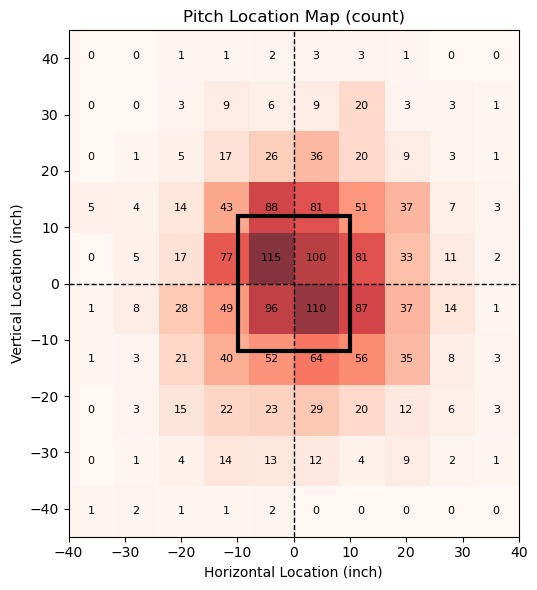

In [13]:
n_pitch_matrix = np.zeros((bins, bins))
for i in range(bins):
    for j in range(bins):
        in_x_bin = (test_events['coordX'] >= x_bin[i]) & (test_events['coordX'] < x_bin[i+1])
        in_y_bin = (test_events['coordY'] >= y_bin[j]) & (test_events['coordY'] < y_bin[j+1])
        n_pitch_matrix[j, i] = np.sum(in_x_bin & in_y_bin)  # note the order of indices for row-major format


print(n_pitch_matrix)
print(np.sum(n_pitch_matrix))


plot_map(n_pitch_matrix, type='count')

In [14]:
called_strikes = test_events[test_events['pitchCode']=='S']
swing_strikes = test_events[test_events['pitchCode'].isin(_swing_tokens)]
called_balls = test_events[test_events['pitchCode']=='B']

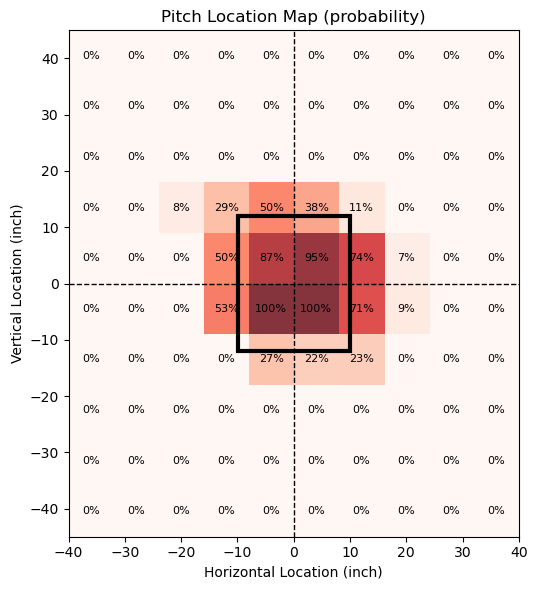

In [15]:
called_strike_matrix = np.zeros((bins, bins))
called_strike_events = get_pitchCode_events(test_events, pitch_code='S')
for i in range(bins):
    for j in range(bins):
        in_x_bin = (called_strike_events['coordX'] >= x_bin[i]) & (called_strike_events['coordX'] < x_bin[i+1])
        in_y_bin = (called_strike_events['coordY'] >= y_bin[j]) & (called_strike_events['coordY'] < y_bin[j+1])
        called_strike_matrix[j,i] = np.sum(in_x_bin & in_y_bin)

called_ball_matrix = np.zeros((bins, bins))
called_ball_events = get_pitchCode_events(test_events, pitch_code='B')
for i in range(bins):
    for j in range(bins):
        in_x_bin = (called_ball_events['coordX'] >= x_bin[i]) & (called_ball_events['coordX'] < x_bin[i+1])
        in_y_bin = (called_ball_events['coordY'] >= y_bin[j]) & (called_ball_events['coordY'] < y_bin[j+1])
        called_ball_matrix[j,i] = np.sum(in_x_bin & in_y_bin)

called_strike_rate = called_strike_matrix / (called_strike_matrix + called_ball_matrix + 1e-6)

plot_map(called_strike_rate, type='probability')


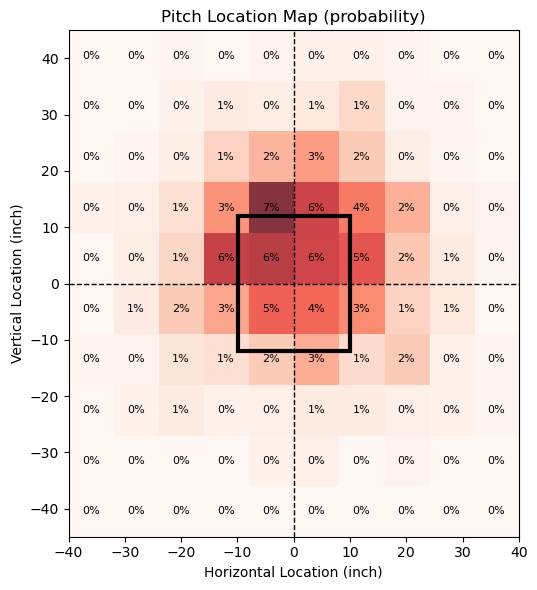

In [16]:
fastball_matrix = np.zeros((bins, bins))
fastballs = get_pitchType_events(test_events, pitch_types='fastball')
for i in range(bins):
    for j in range(bins):
        in_x_bin = (fastballs['coordX'] >= x_bin[i]) & (fastballs['coordX'] < x_bin[i+1])
        in_y_bin = (fastballs['coordY'] >= y_bin[j]) & (fastballs['coordY'] < y_bin[j+1])
        fastball_matrix[j, i] = np.sum(in_x_bin & in_y_bin)  # note the order of indices for row-major format
# print(fastball_matrix)
# print(np.sum(fastball_matrix))

fastball_prob = fastball_matrix / np.sum(fastball_matrix)

plot_map(fastball_prob, type='probability')

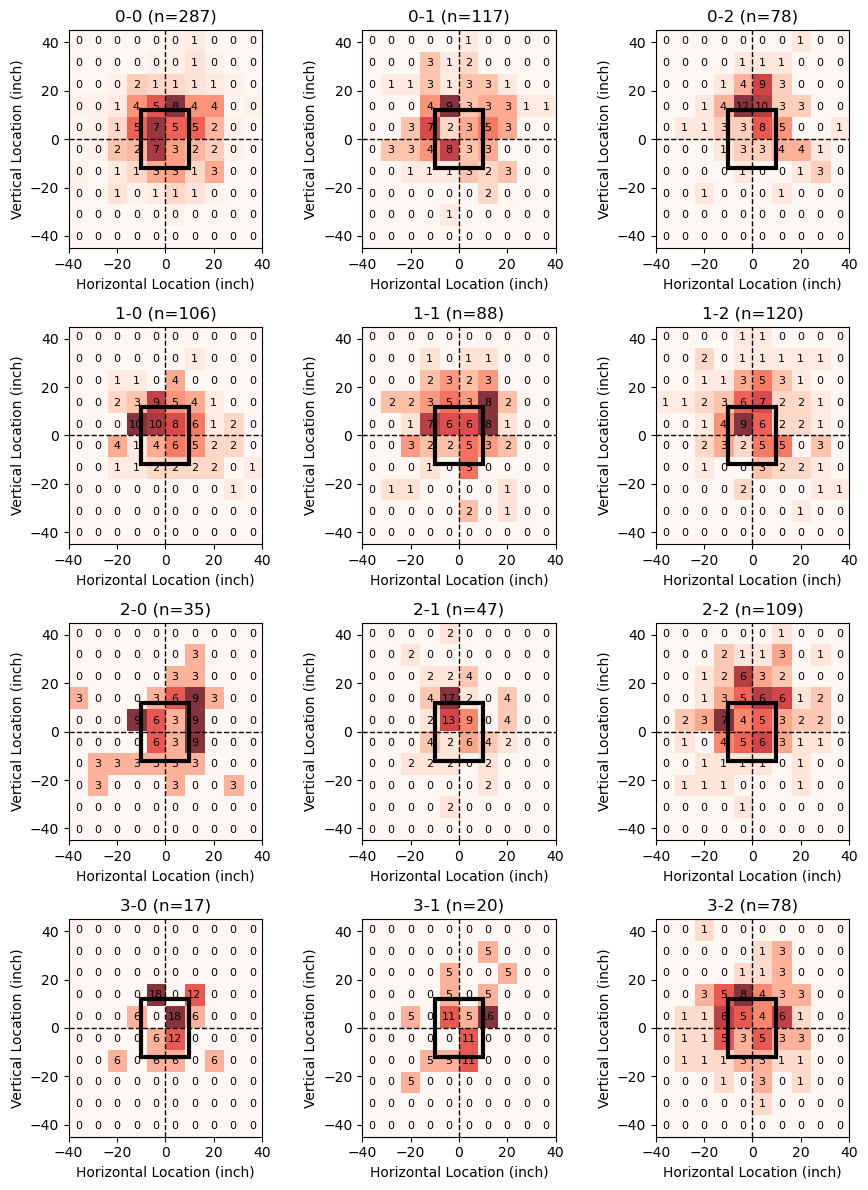

In [17]:
# prepare plotting grid: 4 rows (balls 0..3) x 3 cols (strikes 0..2)
n_balls = 4
n_strikes = 3
fig, axes = plt.subplots(n_balls, n_strikes, figsize=(3*n_strikes, 3*n_balls), tight_layout=True)

prob_maps = []
# loop and plot each count
for b in range(n_balls):
    for s in range(n_strikes):
        map = np.zeros((bins, bins))
        ax = axes[b, s] if (n_balls > 1 and n_strikes > 1) else axes[max(b, s)]
        subset = get_count_events(fastballs, b, s)
        subset = get_pitchType_events(subset, pitch_types='fastball')
        # subset = fastballs[(fastballs['balls'] == b) & (fastballs['strikes'] == s)]
        for i in range(bins):
            for j in range(bins):
                in_x_bin = (subset['coordX'] >= x_bin[i]) & (subset['coordX'] < x_bin[i+1])
                in_y_bin = (subset['coordY'] >= y_bin[j]) & (subset['coordY'] < y_bin[j+1])
                map[j, i] = np.sum(in_x_bin & in_y_bin)  # note the order of indices for row-major format
        map = map / np.sum(map) if np.sum(map) > 0 else map  # normalize to probabilities
        prob_maps.append(map)
        title = f"{b}-{s} (n={len(subset)})"
        ax.imshow(map, extent=(-40, 40, -45, 45), origin='lower', cmap='Reds', alpha=0.8)
        ax.axhline(0, color='black', linestyle='--', linewidth=1)
        ax.axvline(0, color='black', linestyle='--', linewidth=1)
        ax.add_patch(plt.Rectangle((strike_zone[0], strike_zone[2]), strike_zone_width, strike_zone_height,
                                  linewidth=3, edgecolor='k', facecolor='none', linestyle='-', label='Strike Zone'))
        ax.set_title(title)
        ax.set_xlabel('Horizontal Location (inch)')
        ax.set_ylabel('Vertical Location (inch)')
        for i in range(bins):
            for j in range(bins):
                ax.text(x_centers[i], y_centers[j], f"{map[j,i]*100:.0f}",
                        ha='center', va='center', color='black', fontsize=8)
plt.show()
        

/var/folders/_b/sl_t4k5539781f29qf723b080000gn/T/ipykernel_63554/926771255.py:16: RuntimeWarning: invalid value encountered in divide
  fastball_whiff_matrix = whiff_counts / swing_counts


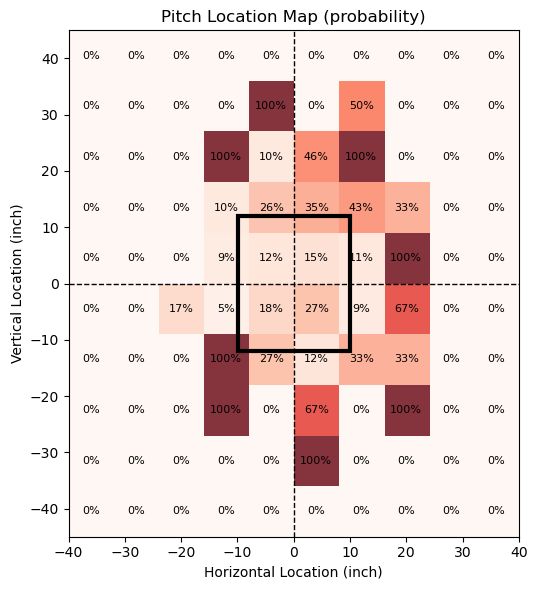

In [18]:
fastball_whiff_matrix = np.zeros((bins, bins))
swing_counts = np.zeros((bins, bins))
whiff_counts = np.zeros((bins, bins))
for i in range(bins):
    for j in range(bins):
        in_x_bin = (fastballs['coordX'] >= x_bin[i]) & (fastballs['coordX'] < x_bin[i+1])
        in_y_bin = (fastballs['coordY'] >= y_bin[j]) & (fastballs['coordY'] < y_bin[j+1])
        in_swing = fastballs['pitchCode'].isin(_swing_tokens)
        in_sw = fastballs['pitchCode']=='SW'
        swing_count = np.sum(in_x_bin & in_y_bin & in_swing) 
        whiff_count = np.sum(in_x_bin & in_y_bin & in_sw)
        swing_counts[j, i] = swing_count if swing_count > 0 else 0
        whiff_counts[j, i] = whiff_count


fastball_whiff_matrix = whiff_counts / swing_counts
fastball_whiff_matrix = np.nan_to_num(fastball_whiff_matrix)  #

plot_map(fastball_whiff_matrix, type='probability')